In [28]:
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


    str  expr
0   -24  20.0
1   -20   3.0
2   -16  13.0
3   -12  19.0
4    -8   9.0
5    -7  28.0
6    -4  11.0
7    -3   6.0
8    -1   2.0
9     0  27.0
10    1  15.0
11    4   4.0
12    5  29.0
13    9  11.0
14   10  14.0
15   13   1.0
16   14   2.0
17   18   1.0


Text(0, 0.5, 'Mean Expression')

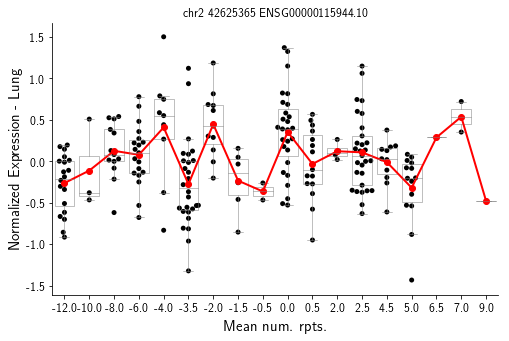

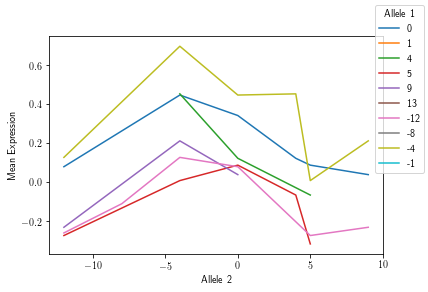

In [32]:
def ExtractData(gene, chrom, start, tissue, newdata=True):
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2 "\\t" $3}' > str_genotypes.tab"""%(chrom.replace("chr",""), start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    if newdata:
        expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Review_Rerun/%s/Corr_Expr.csv"%tissue
    else: expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    allgenes = open(expr,"r").readline().split(",")
    colnum = allgenes.index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)

####### Great example ########
gene = "ENSG00000115944.10"
chrom = "chr2"
start = 42625365
tissue = "Lung"
reflen = 0 # TODO
period = 1 # TODO

# linear p: 0.15069674861460525     quadratic p: 3.235125855915583e-11
###############




# Extract data
ExtractData(gene, chrom, start, tissue)
strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str1","str2"])
strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
expr = pd.read_csv("expr.tab", names=["sample","expr"])
data = pd.merge(strgt, expr)
data["str"] = data["str1"]+data["str2"]



########## Linear #############
boxcol = "gray"
fig = plt.figure()
fig.set_size_inches((8,5))
ax = fig.add_subplot(111)

sns.swarmplot(x="str", y="expr", ax=ax, data=data, color="black", zorder=0)
sns.boxplot(x="str", y="expr", ax=ax, data=data, color="white", linewidth=0.5, 
        boxprops={'facecolor':'None', 'edgecolor': boxcol}, showfliers=False)
# Set box properties
for i,artist in enumerate(ax.artists):
    artist.set_edgecolor(boxcol)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    x = 5
    for j in range(i*x,i*x+x):
        line = ax.lines[j]
        line.set_color(boxcol)
        line.set_mfc(boxcol)
        line.set_mec(boxcol)
totals = data.groupby("str", as_index = False).agg({"expr": len})
print(totals.sort_values("str"))
means = data.groupby("str", as_index = False).agg({"expr": np.mean})
means = means.sort_values("str")
means["num"] = range(means.shape[0])
    
ax.plot(means["num"], means["expr"], color="red", marker="o", linewidth=2)
ax.set_xlabel("Mean num. rpts.", size=15)
ax.set_ylabel("Normalized Expression - %s"%tissue, size=15)
ax.set_xticklabels(["%.1f"%((item*0.5+reflen)/period) for item in sorted(list(set(data["str"])))], size=12)
ax.set_yticklabels(["%.1f"%(item) for item in ax.get_yticks()], size=12)
ax.set_title("")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_title("%s %s %s"%(chrom, start,gene))
plt.suptitle("");
#plt.show()


########## Non-linear (hold one constant) #############
alleles = set(list(data["str1"])+list(data["str2"]))
fig = plt.figure()
ax = fig.add_subplot(111)
for al in alleles:
    adata = data[(data["str1"]==al) | (data["str2"]==al)].copy()
    adata["x"] = adata.apply(lambda x: [x["str1"],x["str2"]][int(x["str1"]==al)], 1) # if str1=al, use str2, else use str2
    xx = adata.groupby("x", as_index=False).agg({"expr": np.mean,"str1": len})
    xx = xx[xx["str1"]>=3]
    ax.plot(xx["x"],xx["expr"], label=al)
fig.legend(title="Allele 1")
ax.set_xlabel("Allele 2")
ax.set_ylabel("Mean Expression")
